In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from src.scripts.evaluate_nested_cv_pac import print_results

In [3]:
with open('/workspace/visiomel-2023/nested-kfold-checkpoints/0-giddy-sweep-13/cv_results.pkl', 'rb') as f:
    results = pickle.load(f)

# fold_indices_test = [0]  # for no outer CV
fold_indices_test = range(5)

In [4]:
print_results(results)

Fold 0
	log_loss: 0.43841182224537617
	f1_score: 0.4375
	roc_auc: 0.7892570487754682
	log_loss_bs: 0.5935543546681198
	f1_score_bs: 0.6006399545634203
	roc_auc_bs: 0.7917517577068686
	log_loss_val: 0.44696049399778043
	f1_score_val: 0.5067874238751771
	roc_auc_val: 0.7915403048545719
	log_loss_bs_val: 0.597071405243426
	f1_score_bs_val: 0.6823190142533994
	roc_auc_bs_val: 0.791706849792907

Fold 1
	log_loss: 0.4961205783996079
	f1_score: 0.4878048780487806
	roc_auc: 0.7781912144702843
	log_loss_bs: 0.5828800676574177
	f1_score_bs: 0.7272982873503661
	roc_auc_bs: 0.7779588967009194
	log_loss_val: 0.4892749782489941
	f1_score_val: 0.4722735482577979
	roc_auc_val: 0.7814778102769653
	log_loss_bs_val: 0.6296647821946857
	f1_score_bs_val: 0.6945061708147503
	roc_auc_bs_val: 0.7824743944636678

Fold 2
	log_loss: 0.4959205308762111
	f1_score: 0.42857142857142855
	roc_auc: 0.7582174462705435
	log_loss_bs: 0.6469244309950786
	f1_score_bs: 0.6448433687001405
	roc_auc_bs: 0.7594784580498866
	log_

In [5]:
for fold_index_test in fold_indices_test:
    if fold_index_test not in results:
        print(f'Outer fold {fold_index_test} not found')
        continue
    for fold_index in range(5):
        if fold_index not in results[fold_index_test]['data']['pac']:
            print(f'Fold {fold_index} not found')
            continue

class: no relapse, fold: 0, mean: 0.26727139949798584, min: 0.09942630678415298, max: 0.8556890487670898
class: relapse, fold: 0, mean: 0.5079376101493835, min: 0.11550810188055038, max: 0.8499826192855835


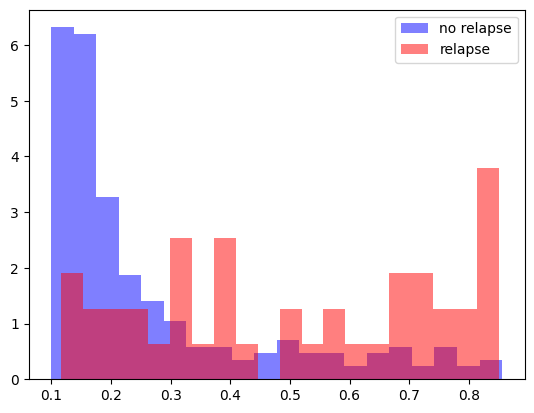

class: no relapse, fold: 1, mean: 0.3120577335357666, min: 0.08224377781152725, max: 0.8754751086235046
class: relapse, fold: 1, mean: 0.5591122508049011, min: 0.11529441922903061, max: 0.8794881701469421


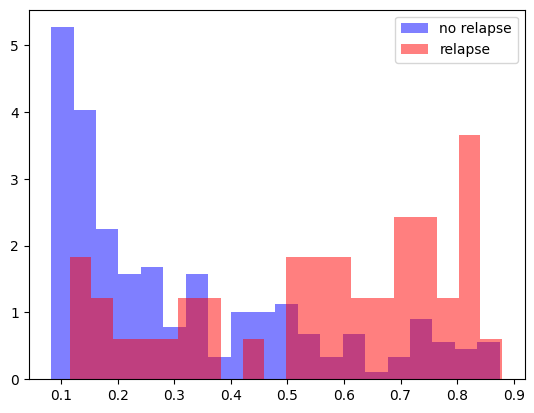

class: no relapse, fold: 2, mean: 0.27608728408813477, min: 0.04927805811166763, max: 0.8852384686470032
class: relapse, fold: 2, mean: 0.5256195068359375, min: 0.05844050645828247, max: 0.8984384536743164


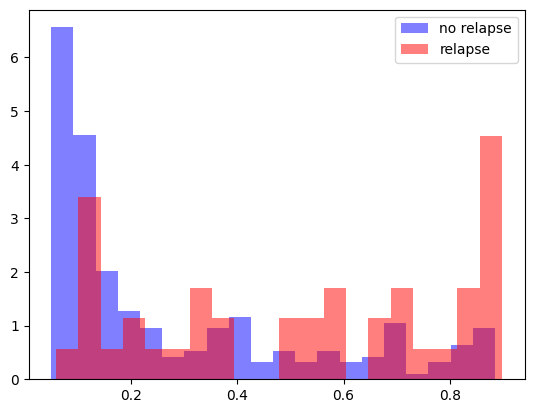

class: no relapse, fold: 3, mean: 0.26119905710220337, min: 0.06305690854787827, max: 0.8580365180969238
class: relapse, fold: 3, mean: 0.5581126809120178, min: 0.07356163114309311, max: 0.8616668581962585


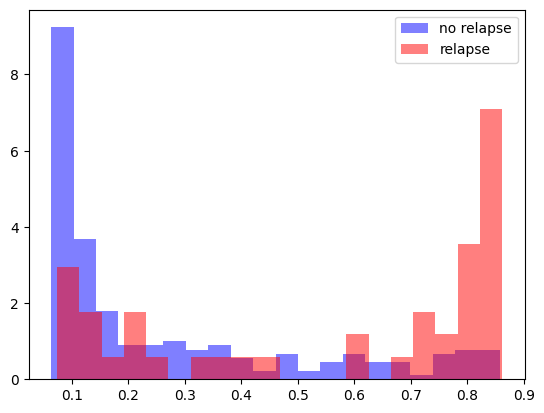

class: no relapse, fold: 4, mean: 0.2372623234987259, min: 0.046382706612348557, max: 0.8710315823554993
class: relapse, fold: 4, mean: 0.5866380929946899, min: 0.054854799062013626, max: 0.8748737573623657


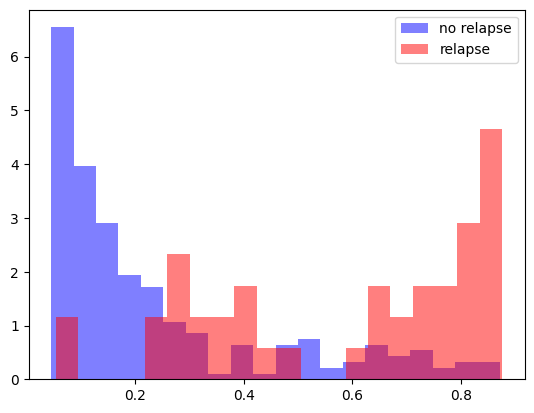

In [16]:
# plot hists of probabilities for class 0 and 1
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'

if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        for class_index in range(2):
            class_name = ['no relapse', 'relapse'][class_index]
            class_color = ['blue', 'red'][class_index]
            probs = \
                (results[fold_index_test]['data']['pac']['mean'])
            gt = results[fold_index_test]['data']['gt']
            plt.hist(probs[gt == class_index], bins=20, density=True, color=class_color, alpha=0.5, label=class_name)
            print(f'class: {class_name}, fold: {fold_index_test}, mean: {probs[gt == class_index].mean()}, min: {probs[gt == class_index].min()}, max: {probs[gt == class_index].max()}')
        plt.legend()
        plt.show()

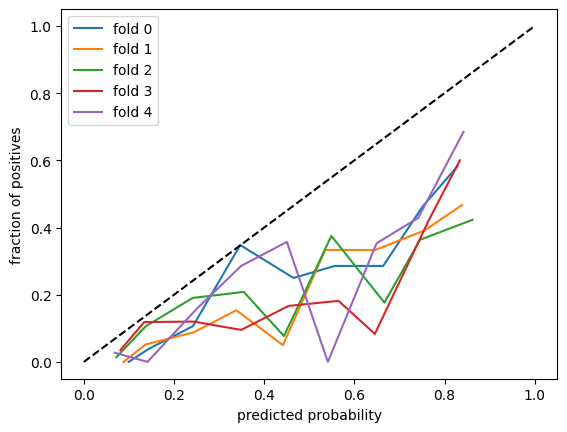

In [7]:
# plot calibration curves
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'

from sklearn.calibration import calibration_curve


if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        prob_true, prob_pred = calibration_curve(
            results[fold_index_test]['data']['gt'],
            results[fold_index_test]['data']['pac']['mean'],
            n_bins=10,
            strategy='uniform',
        )
        plt.plot(prob_pred, prob_true, label=f'fold {fold_index_test}')
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

In [18]:
from sklearn.calibration import _SigmoidCalibration
from sklearn.isotonic import IsotonicRegression


if fold_indices_test is not None:
    method = "sigmoid"
    for fold_index_test in fold_indices_test:
        for fold_index in range(5):
            y_proba_val = results[fold_index_test]['data']['pac'][fold_index]['y_proba_val']
            y_val = results[fold_index_test]['data']['pac'][fold_index]['gt_val']

            class_idx = 1
            if method == "isotonic":
                calibrator = IsotonicRegression(out_of_bounds="clip")
            else:  # "sigmoid"
                calibrator = _SigmoidCalibration()
            calibrator.fit(y_proba_val, y_val, None)

            # recalculate probabilities
            results[fold_index_test]['data']['pac'][fold_index]['y_proba_test_calibrated'] = \
                calibrator.predict(results[fold_index_test]['data']['pac'][fold_index]['y_proba_test'])
        results[fold_index_test]['data']['pac']['mean_calibrated'] = \
            sum(results[fold_index_test]['data']['pac'][fold_index]['y_proba_test_calibrated'] for fold_index in range(5)) / 5

class: no relapse, fold: 0, mean: 0.13324129581451416, min: 0.05596504732966423, max: 0.5771997570991516
class: relapse, fold: 0, mean: 0.2886619567871094, min: 0.05975113436579704, max: 0.5715764164924622


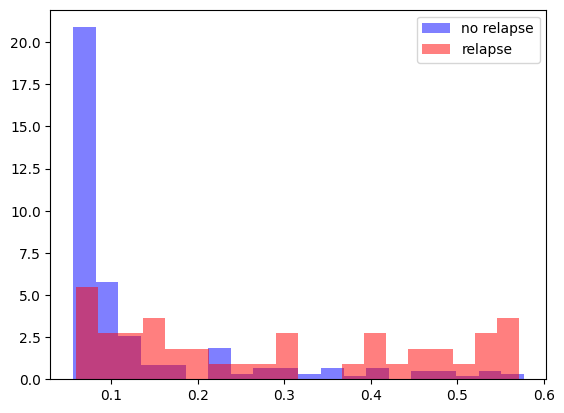

class: no relapse, fold: 1, mean: 0.14831458032131195, min: 0.051470302045345306, max: 0.5093474388122559
class: relapse, fold: 1, mean: 0.2821923494338989, min: 0.05793444439768791, max: 0.5111533403396606


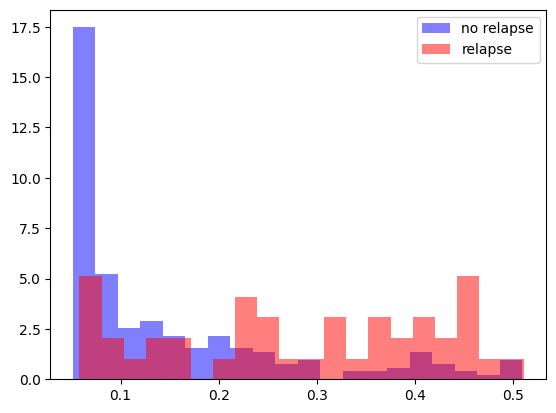

class: no relapse, fold: 2, mean: 0.14261572062969208, min: 0.04814191907644272, max: 0.5050413012504578
class: relapse, fold: 2, mean: 0.27628183364868164, min: 0.04931790754199028, max: 0.5169557929039001


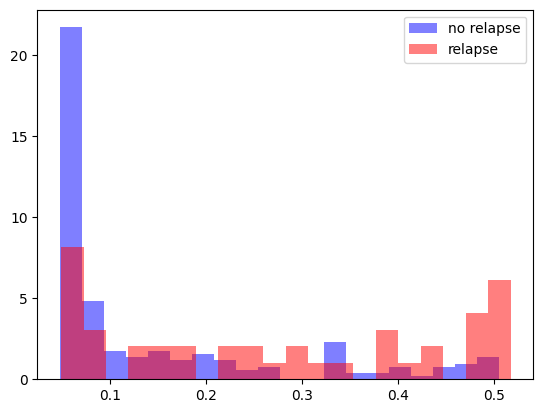

class: no relapse, fold: 3, mean: 0.12714923918247223, min: 0.04908100143074989, max: 0.4603798985481262
class: relapse, fold: 3, mean: 0.28083279728889465, min: 0.05089659243822098, max: 0.4635874330997467


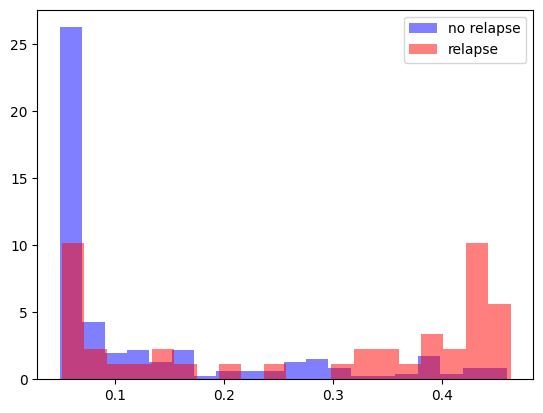

class: no relapse, fold: 4, mean: 0.1287851184606552, min: 0.05984367057681084, max: 0.474203884601593
class: relapse, fold: 4, mean: 0.2954293489456177, min: 0.061162661761045456, max: 0.4744643568992615


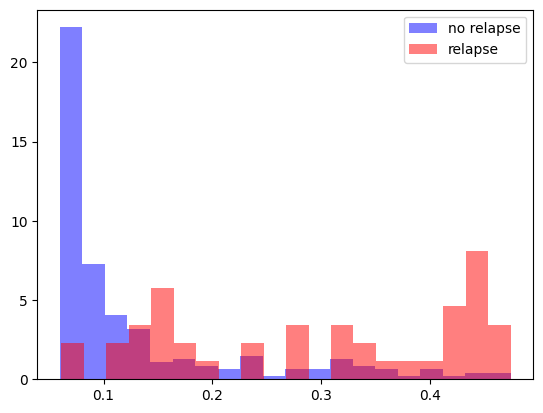

In [19]:
# plot hists of probabilities for class 0 and 1
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'

if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        for class_index in range(2):
            class_name = ['no relapse', 'relapse'][class_index]
            class_color = ['blue', 'red'][class_index]
            probs = \
                (results[fold_index_test]['data']['pac']['mean_calibrated'])
            gt = results[fold_index_test]['data']['gt']
            plt.hist(probs[gt == class_index], bins=20, density=True, color=class_color, alpha=0.5, label=class_name)
            print(f'class: {class_name}, fold: {fold_index_test}, mean: {probs[gt == class_index].mean()}, min: {probs[gt == class_index].min()}, max: {probs[gt == class_index].max()}')
        plt.legend()
        plt.show()

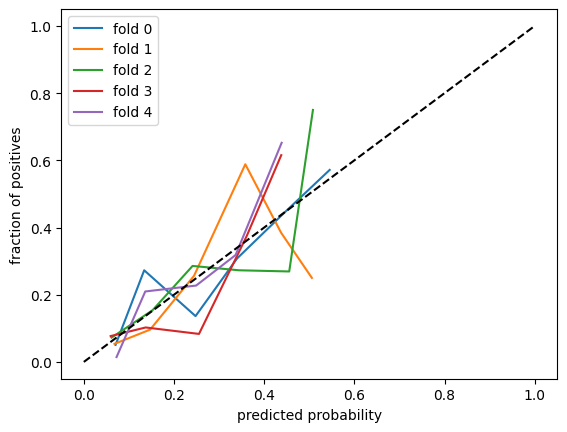

In [20]:
# plot calibration curves
# for each fold
# probs of class 1: results[fold_index]['data']['pac']['mean']
# gt: results[fold_index]['data']['gt']
# fold_index: 0, 1, 2, 3, 4
# class_index: 0, 1
# class_name: 'no relapse', 'relapse'
# class_color: 'blue', 'red'

from sklearn.calibration import calibration_curve


if fold_indices_test is not None:
    for fold_index_test in fold_indices_test:
        prob_true, prob_pred = calibration_curve(
            results[fold_index_test]['data']['gt'],
            results[fold_index_test]['data']['pac']['mean_calibrated'],
            n_bins=10,
            strategy='uniform',
        )
        plt.plot(prob_pred, prob_true, label=f'fold {fold_index_test}')
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

In [21]:
from sklearn.metrics import f1_score, log_loss, roc_auc_score

from scripts.evaluate_nested_cv_pac import bootstrap_metrics


if fold_indices_test is not None:
    n_bootstrap = 1000
    for fold_index_test in fold_indices_test:

        data = results[fold_index_test]['data']
        # Metrics
        # Log loss
        results[fold_index_test]['log_loss_calibrated'] = log_loss(data['gt'], data['pac']['mean_calibrated'], eps=1e-16)

        # F1 score
        results[fold_index_test]['f1_score_calibrated'] = f1_score(
            data['gt'],
            data['pac']['mean_calibrated'] > 0.5,
        )

        # ROC AUC
        results[fold_index_test]['roc_auc_calibrated'] = roc_auc_score(
            data['gt'],
            data['pac']['mean_calibrated'],
        )

        # Bootstrap metrics on n_bootstrap test sets with downsampled negative class
        bootstrap_metrics_dict = bootstrap_metrics(
            data['gt'], 
            data['pac']['mean_calibrated'],
            n_bootstrap=n_bootstrap,
            replace=True,
        )
        for metric_name, metric_value in bootstrap_metrics_dict.items():
            results[fold_index_test][metric_name + '_calibrated'] = metric_value

In [22]:
print_results(results)

Fold 0
	log_loss: 0.43841182224537617
	f1_score: 0.4375
	roc_auc: 0.7892570487754682
	log_loss_bs: 0.5935543546681198
	f1_score_bs: 0.6006399545634203
	roc_auc_bs: 0.7917517577068686
	log_loss_val: 0.44696049399778043
	f1_score_val: 0.5067874238751771
	roc_auc_val: 0.7915403048545719
	log_loss_bs_val: 0.597071405243426
	f1_score_bs_val: 0.6823190142533994
	roc_auc_bs_val: 0.791706849792907
	log_loss_calibrated: 0.36751349864527944
	f1_score_calibrated: 0.2807017543859649
	roc_auc_calibrated: 0.792138300061741
	log_loss_bs_calibrated: 0.818497816003141
	f1_score_bs_calibrated: 0.30697838597461236
	roc_auc_bs_calibrated: 0.7927901568415359

Fold 1
	log_loss: 0.4961205783996079
	f1_score: 0.4878048780487806
	roc_auc: 0.7781912144702843
	log_loss_bs: 0.5828800676574177
	f1_score_bs: 0.7272982873503661
	roc_auc_bs: 0.7779588967009194
	log_loss_val: 0.4892749782489941
	f1_score_val: 0.4722735482577979
	roc_auc_val: 0.7814778102769653
	log_loss_bs_val: 0.6296647821946857
	f1_score_bs_val: 0.6

: 